## Импорты и установка модулей и библиотек

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import RobustScaler

## Загрузка и подготовка данных

In [3]:
df = pd.read_csv('/content/HistoricalData_1742404356306.csv')
df['Close/Last'] = df['Close/Last'].str.replace('$', '').astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Close/Last']].sort_values('Date')

## Используемые функции

In [4]:
# Создание дополнительных признаков
def create_features(df):
    # Лаги от 1 до 30 дней
    for lag in range(1, 31):
        df[f'lag_{lag}'] = df['Close/Last'].shift(lag)

    # Скользящие средние
    df['rolling_7_mean'] = df['Close/Last'].rolling(window=7).mean().shift(1)
    df['rolling_14_mean'] = df['Close/Last'].rolling(window=14).mean().shift(1)
    df['rolling_30_mean'] = df['Close/Last'].rolling(window=30).mean().shift(1)

    # Временные признаки
    df['day'] = df['Date'].dt.day
    df['weekday'] = df['Date'].dt.weekday
    df['week'] = df['Date'].dt.isocalendar().week
    df['month'] = df['Date'].dt.month
    df['quarter'] = df['Date'].dt.quarter
    df['year'] = df['Date'].dt.year

    # Сезонные признаки
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['is_month_start'] = df['Date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['Date'].dt.is_month_end.astype(int)

    return df

In [16]:
# Функция для оценки моделей
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    mape = np.mean(np.abs((y_test - pred) / y_test)) * 100
    rmse = np.sqrt(mean_squared_error(y_test, pred))

    return {'Model': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}

## Применение функции по генерации признаков, заполнение пропусков и сплитование данных

In [5]:
df = create_features(df)

In [6]:
split_date = df['Date'].max() - pd.Timedelta(days=76)  # Последние 76 дней для теста(c января 2025 года)
train = df[df['Date'] <= split_date].copy()
test = df[df['Date'] > split_date].copy()

In [7]:
train = train.interpolate().dropna()
test = test.interpolate().dropna()

In [8]:
features = [col for col in df.columns if col not in ['Date', 'Close/Last']]
X_train, y_train = train[features], train['Close/Last']
X_test, y_test = test[features], test['Close/Last']

## Масштабирование данных

In [9]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели и их гиперпараметры

In [10]:
models = [
    ('Random Forest', RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )),
    ('XGBoost', XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )),
    ('LightGBM', LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        num_leaves=30,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )),
    ('CatBoost', CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=7,
        l2_leaf_reg=3,
        random_seed=42,
        verbose=0
    ))
]

In [11]:
# Оценка моделей
results = []
for name, model in models:
    results.append(evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, name))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8774
[LightGBM] [Info] Number of data points in the train set: 1175, number of used features: 42
[LightGBM] [Info] Start training from score 149.978695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Вывод результатов по величине ошибок

In [12]:
metrics_df = pd.DataFrame(results).set_index('Model')
print("\nМетрики моделей:")
print(metrics_df.sort_values('MAE'))


Метрики моделей:
                     MAE      MAPE       RMSE
Model                                        
XGBoost         8.356576  3.756729   9.978906
Random Forest   8.699906  3.969410  10.072144
LightGBM        9.904117  4.605200  11.634620
CatBoost       19.698323  8.638805  22.825872


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


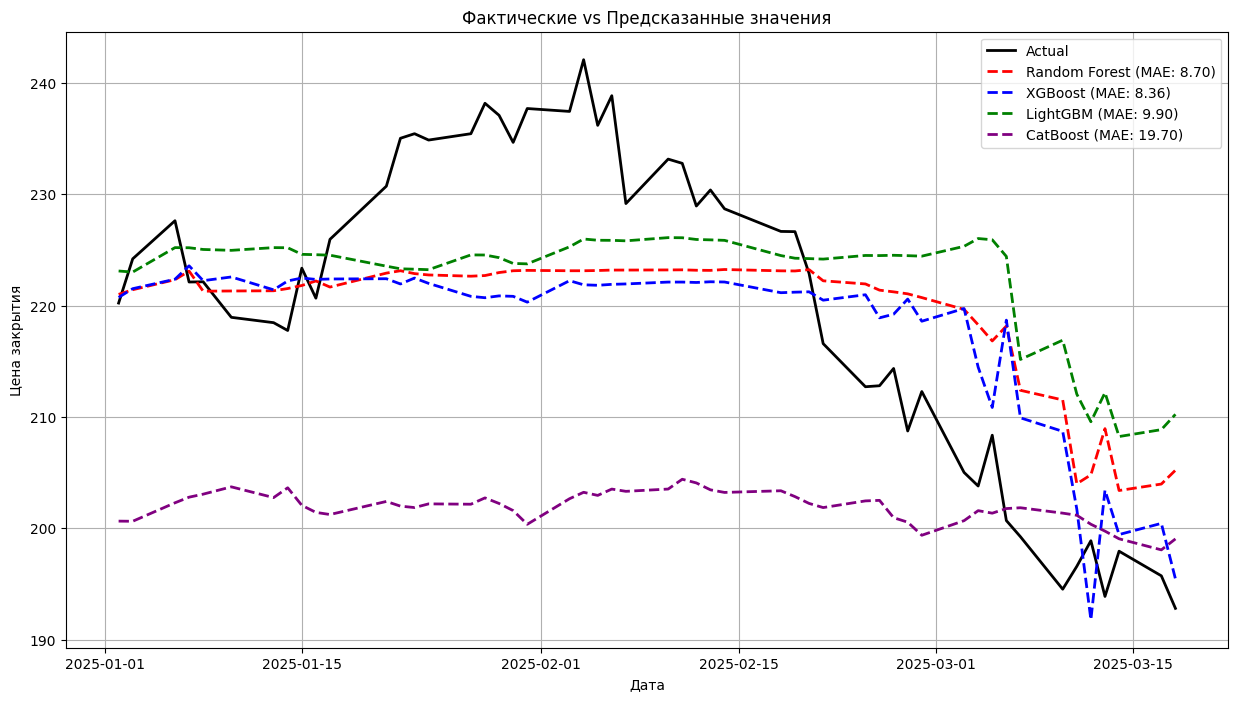

In [13]:
plt.figure(figsize=(15, 8))
plt.plot(test['Date'], y_test, label='Actual', linewidth=2, color='black')
colors = ['red', 'blue', 'green', 'purple']

for i, (name, model) in enumerate(models):
    pred = model.predict(X_test_scaled)
    plt.plot(test['Date'], pred, '--',
             linewidth=2,
             color=colors[i],
             label=f'{name} (MAE: {mean_absolute_error(y_test, pred):.2f})')

plt.title('Фактические vs Предсказанные значения')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid()
plt.show()

## Ансамблирование через простое усреднение предсказаний

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Метрики ансамбля (усреднение всех моделей):
MAE: 10.1771
MAPE: 4.5486%
RMSE: 11.9409


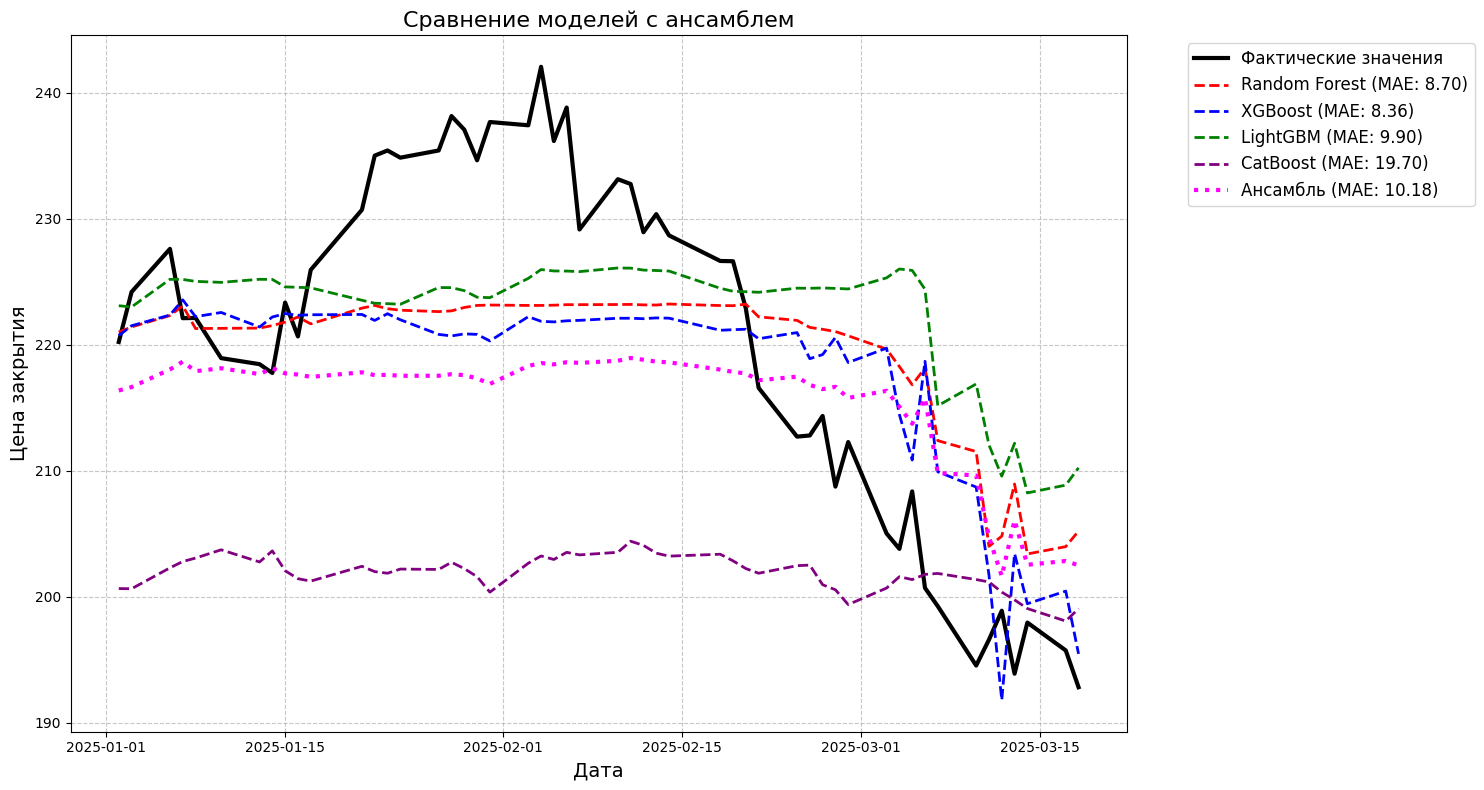

In [14]:
predictions = []
for name, model in models:
    pred = model.predict(X_test_scaled)
    predictions.append(pred)

ensemble_pred = np.mean(predictions, axis=0)

ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_mape = np.mean(np.abs((y_test - ensemble_pred) / y_test)) * 100
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))

print("\nМетрики ансамбля (усреднение всех моделей):")
print(f"MAE: {ensemble_mae:.4f}")
print(f"MAPE: {ensemble_mape:.4f}%")
print(f"RMSE: {ensemble_rmse:.4f}")

# Дополнительная визуализация с ансамблем
plt.figure(figsize=(15, 8))
plt.plot(test['Date'], y_test, label='Фактические значения', linewidth=3, color='black')

for i, (name, model) in enumerate(models):
    pred = model.predict(X_test_scaled)
    plt.plot(test['Date'], pred, '--',
             linewidth=2,
             color=colors[i],
             label=f'{name} (MAE: {mean_absolute_error(y_test, pred):.2f})')

plt.plot(test['Date'], ensemble_pred, ':',
         linewidth=3,
         color='magenta',
         label=f'Ансамбль (MAE: {mean_absolute_error(y_test, ensemble_pred):.2f})')

plt.title('Сравнение моделей с ансамблем', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Цена закрытия', fontsize=14)
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## красивая табличка с метриками

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


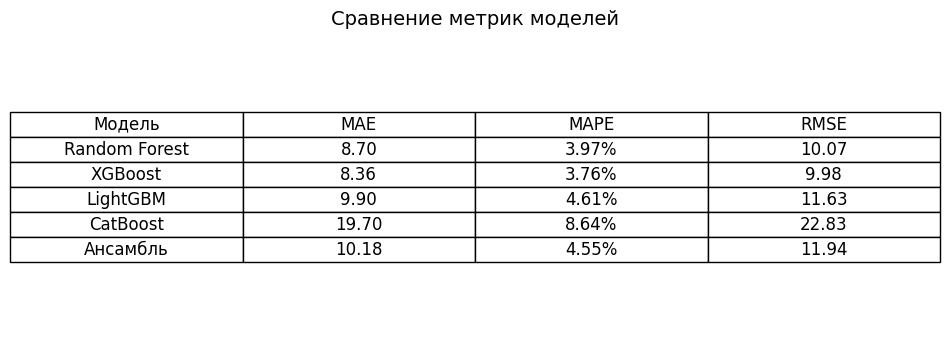

In [15]:
metric_data = []
for name, model in models:
    pred = model.predict(X_test_scaled)
    metric_data.append([
        name,
        f"{mean_absolute_error(y_test, pred):.2f}",
        f"{np.mean(np.abs((y_test - pred)/y_test))*100:.2f}%",
        f"{np.sqrt(mean_squared_error(y_test, pred)):.2f}"
    ])

metric_data.append([
    "Ансамбль",
    f"{mean_absolute_error(y_test, ensemble_pred):.2f}",
    f"{np.mean(np.abs((y_test - ensemble_pred)/y_test))*100:.2f}%",
    f"{np.sqrt(mean_squared_error(y_test, ensemble_pred)):.2f}"
])

fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')
table = ax.table(cellText=metric_data,
                 colLabels=['Модель', 'MAE', 'MAPE', 'RMSE'],
                 loc='center',
                 cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
plt.title('Сравнение метрик моделей', fontsize=14)
plt.show()